In [1]:
from data_modules.ocelot import OcelotDataModule
from models.comp_seg import CompositeSegmentationModel
from models.dynunet import DynUNetModel
from ocelot_util import normalize_crop_coords_batch
from lightning.pytorch import seed_everything

seed_everything(42)

[rank: 0] Seed set to 42


42

In [2]:
data_module = OcelotDataModule(batch_size=4, num_workers=1)
data_module.prepare_data()
data_module.setup()
train_set = data_module.train_set

Train: 395 | Val: 137 | Test: 124


In [3]:
train_loader = data_module.train_dataloader()
batch = next(iter(train_loader))
y_t = batch["label_tissue"]
y_c = batch["label_cropped_tissue"]
meta_batch = batch["meta"]
print(meta_batch)
cropped_coords = normalize_crop_coords_batch(meta_batch)
print(cropped_coords)
print("Available keys in batch:", batch.keys())

{'slide_name': ['TCGA-D7-6519-01Z-00-DX1.5f7dcb29-030f-4011-affe-47dab4b9da03', 'TCGA-MG-AAMC-01Z-00-DX2.9DFE44B1-A918-41E9-BE64-A1A965B61CBD', 'TCGA-NP-A5H1-01Z-00-DX1.ABF28359-B224-4C36-9217-C6DB90692848', 'TCGA-G2-A2EJ-01Z-00-DX6.6EFFECC5-45F4-4828-8AD7-84E060E6FC9D'], 'cell_patch': {'x_start': tensor([104313,  48902,  22127,  77088]), 'y_start': tensor([36351, 29972, 18966, 33726]), 'x_end': tensor([105103,  49690,  22917,  77890]), 'y_end': tensor([37141, 30760, 19756, 34528]), 'resized_mpp_x': tensor([0.1944, 0.1943, 0.1944, 0.1942], dtype=torch.float64), 'resized_mpp_y': tensor([0.1944, 0.1943, 0.1944, 0.1942], dtype=torch.float64)}, 'tissue_patch': {'x_start': tensor([104313,  47325,  22127,  77088]), 'y_start': tensor([34771, 28395, 18966, 32120]), 'x_end': tensor([107473,  50479,  25287,  80299]), 'y_end': tensor([37931, 31549, 22126, 35331]), 'resized_mpp_x': tensor([0.7777, 0.7777, 0.7777, 0.7777], dtype=torch.float64), 'resized_mpp_y': tensor([0.7777, 0.7777, 0.7777, 0.777

In [4]:
dn_l = DynUNetModel(
    lr = 0.001,
    spatial_dims=2,
    in_channels=3,
    out_channels=2,
    kernel_size=[
        [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]
    ],
    strides=[
        [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]
    ],
    upsample_kernel_size=[
        [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]
    ]
)
dn_s = DynUNetModel(
    lr = 0.001,
    spatial_dims=2,
    in_channels=5,
    out_channels=2,
    kernel_size=[
        [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3], [3, 3]
    ],
    strides=[
        [1, 1], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]
    ],
    upsample_kernel_size=[
        [2, 2], [2, 2], [2, 2], [2, 2], [2, 2], [2, 2]
    ]
)
csm = CompositeSegmentationModel(ts_net=dn_l, cs_net=dn_s)


In [5]:
tissue_pred_to_crop= csm.forward(
    batch, data_module, cropped_coords,
     tissue_label=batch.get("label_tissue"), train_mode=True,
      parallelize_invert = False, only_tissue_to_crop = True 
)

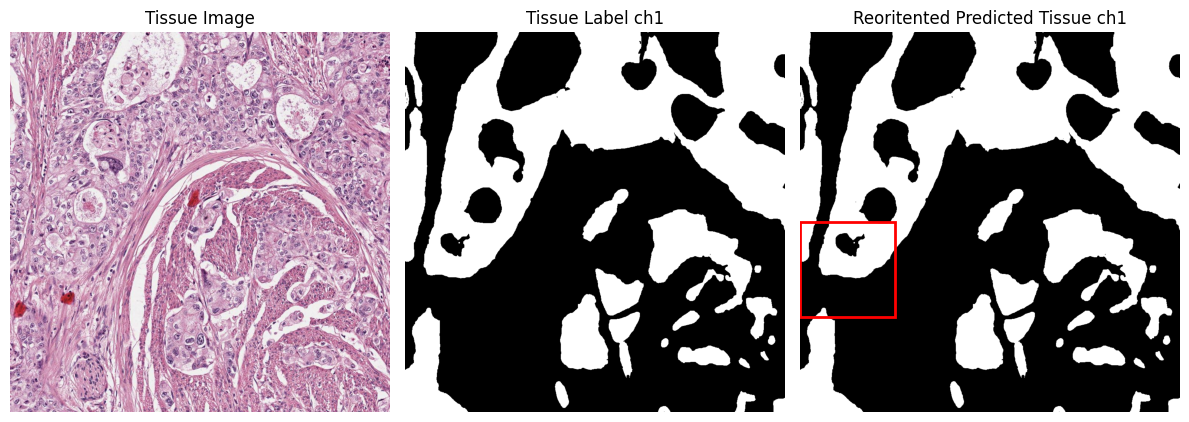

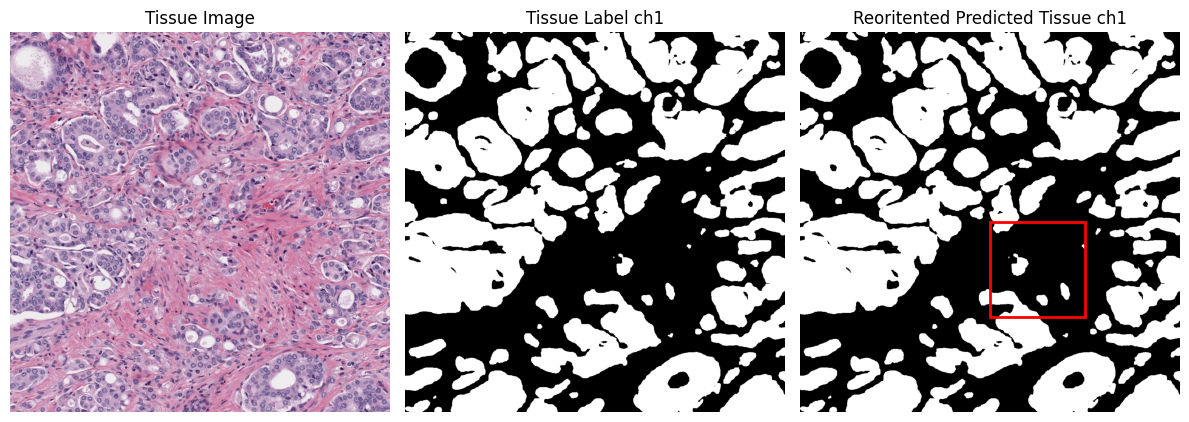

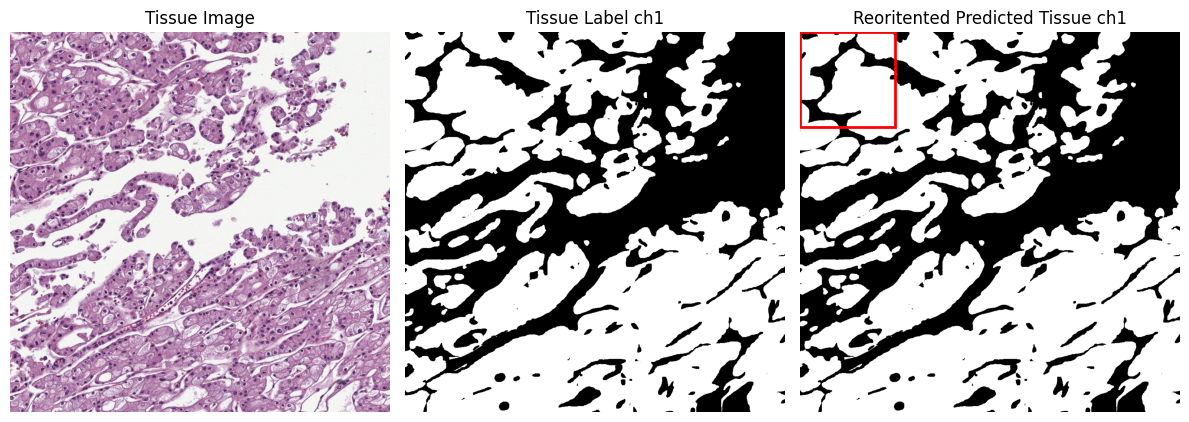

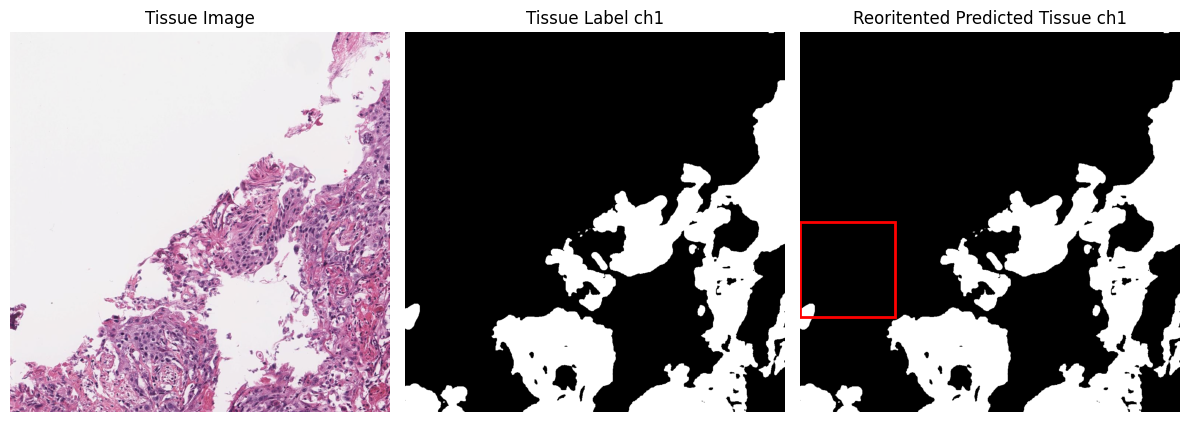

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def normalize_image(img):
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())    
    return img

def visualize_results(tissue_img, label_tissue, tissue_pred_reoriented, coords):
    tissue_img = normalize_image(tissue_img)
    
    if tissue_img.ndim == 3 and tissue_img.shape[0] == 3:
        tissue_img = np.transpose(tissue_img, (1, 2, 0))  # Convert (3, height, width) to (height, width, 3)
    

    # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 20))

    # Plot the tissue image (r1c1)
    axes[0].imshow(tissue_img)
    axes[0].set_title("Tissue Image")
    axes[0].axis('off')


    # Plot the tissue label (r2c1)
    axes[1].imshow(label_tissue[0], cmap='gray')
    axes[1].set_title("Tissue Label ch1")
    axes[1].axis('off')


    
    # Plot the predicted tissue (r3c1)
    axes[2].imshow(tissue_pred_reoriented.detach().numpy()[0], cmap='gray')
    axes[2].set_title("Reoritented Predicted Tissue ch1")
    axes[2].axis('off')

    if coords is not None:
            x1, y1, x2, y2 = coords
            # Add a rectangle to the tissue prediction image to show the crop area
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            axes[2].add_patch(rect)

  
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
for i in range(4):
    tissue_img = batch['img_tissue'][i]
    label_tissue = batch['label_tissue'][i]
    label_cell = batch['label_cropped_tissue'][i]

    tissue_pred_reoriented = tissue_pred_to_crop[i]
    coords = cropped_coords[i]
    visualize_results(tissue_img = tissue_img, label_tissue = label_tissue, tissue_pred_reoriented = tissue_pred_reoriented, coords = coords)

In [7]:
tissue_pred, cell_pred, re_augmented_crop, tissue_pred_to_crop = csm.forward(
    batch, data_module, cropped_coords, tissue_label=batch.get("label_tissue"), train_mode=True, only_tissue_to_crop = False #Setting to true in order to check whether cropping works
)

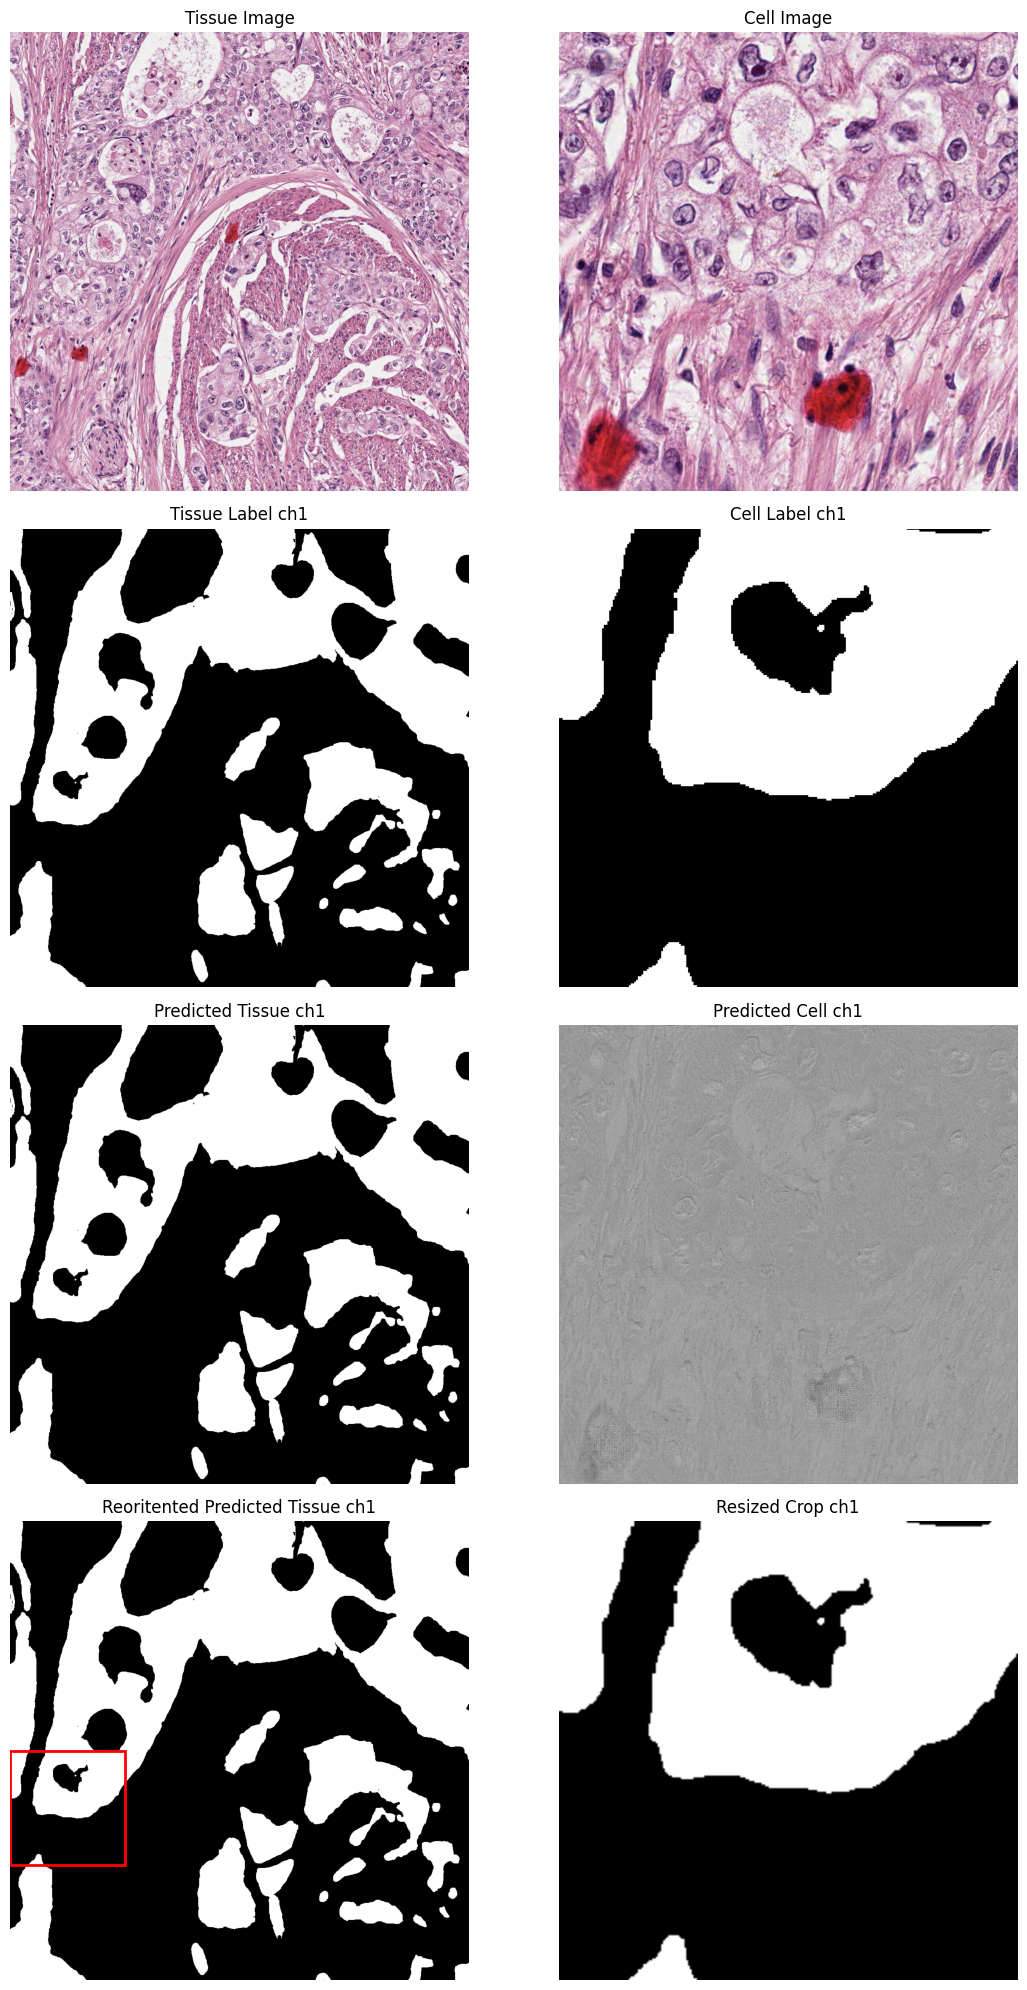

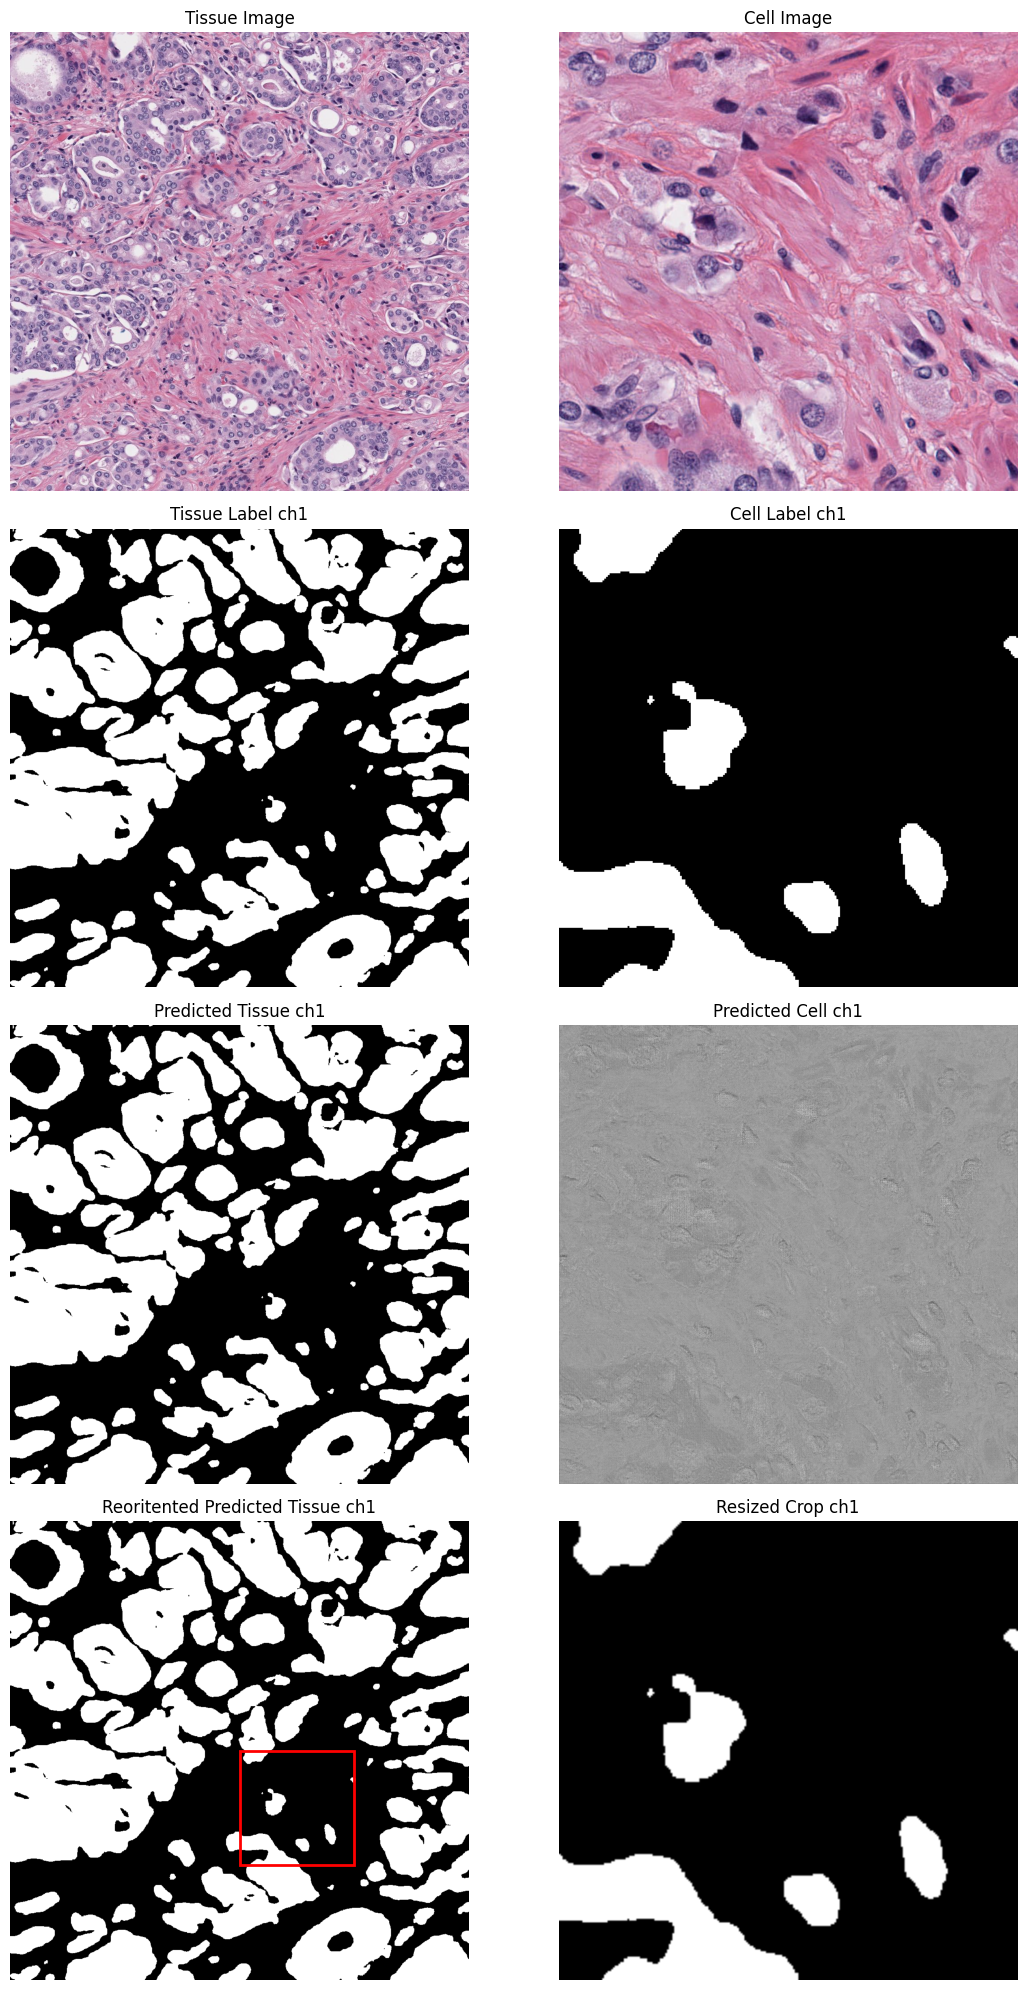

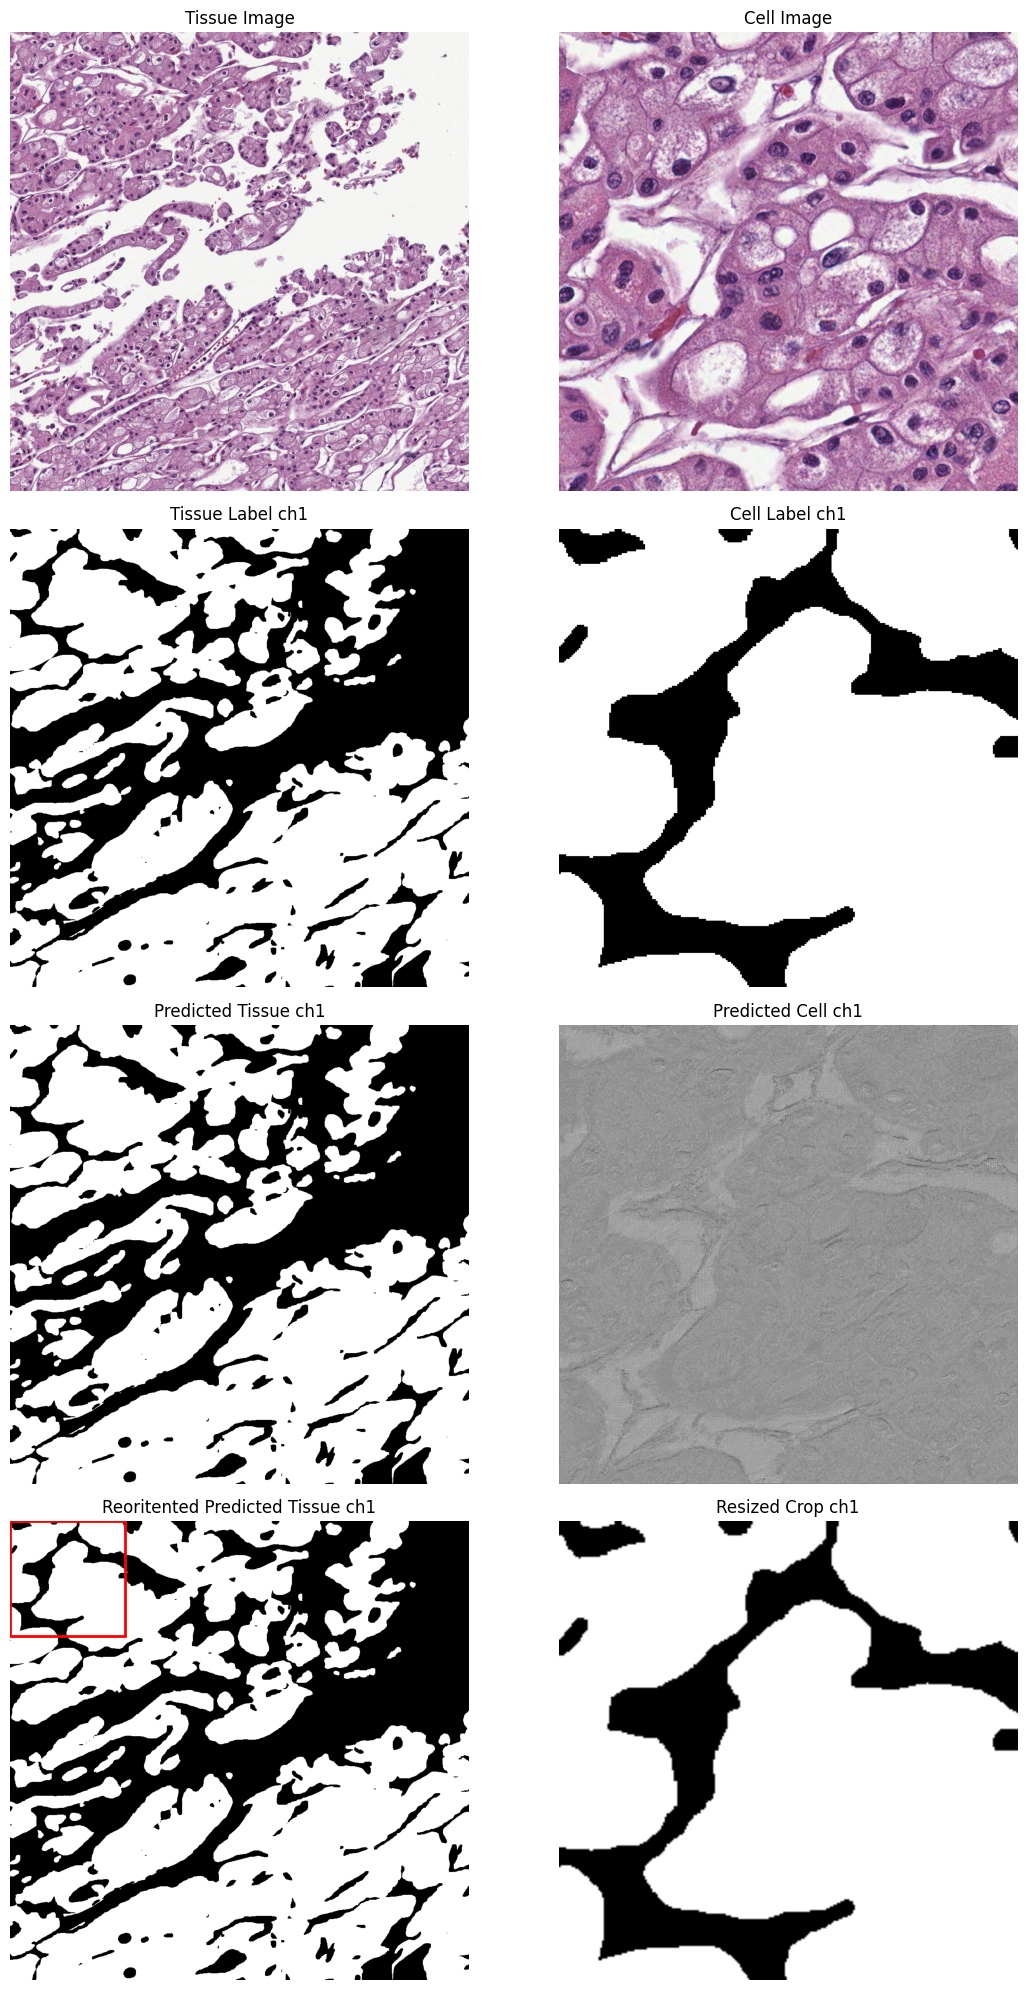

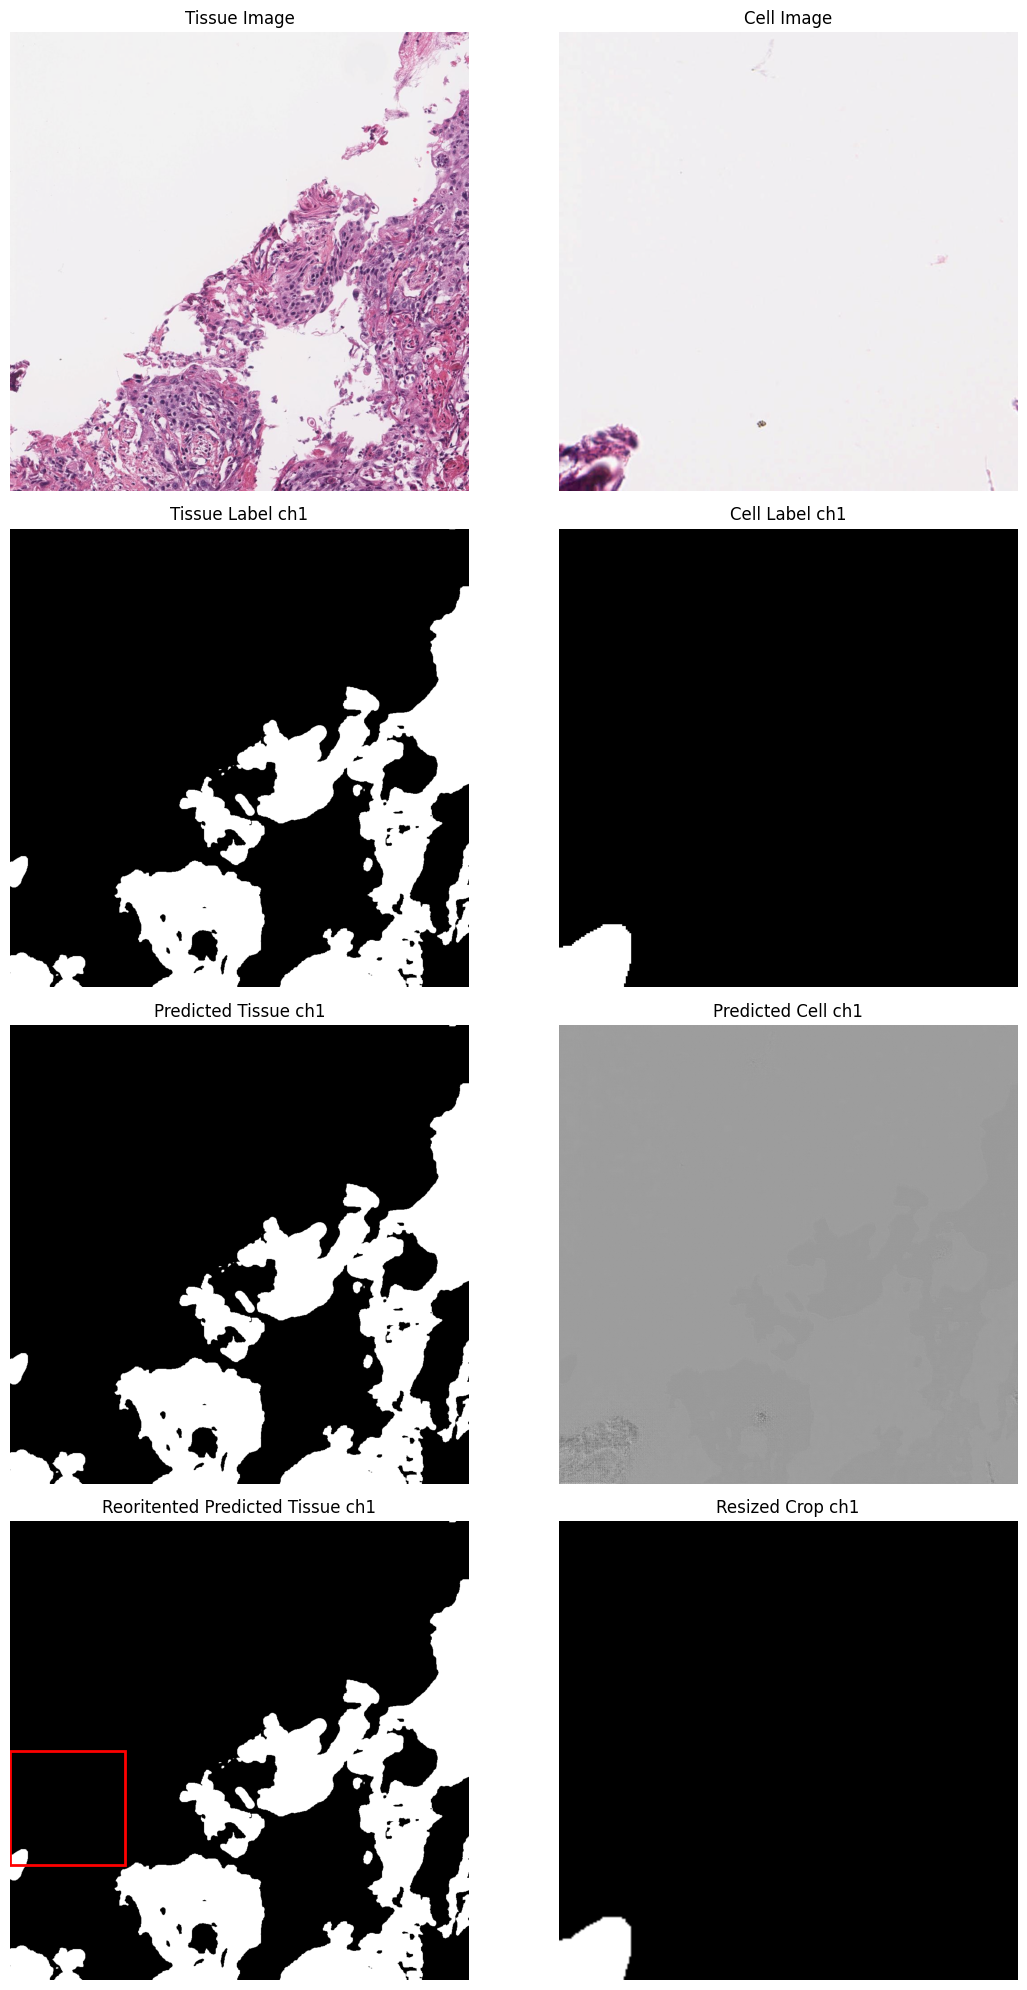

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def normalize_image(img):
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())    
    return img

def visualize_results(tissue_img, cell_img, label_tissue, label_cell, pred_tissue, pred_cell, tissue_pred_to_crop, resized_crop, coords):
    tissue_img = normalize_image(tissue_img)
    cell_img = normalize_image(cell_img)
    pred_tissue = normalize_image(pred_tissue)
    pred_cell = normalize_image(pred_cell)
    resized_crop = normalize_image(resized_crop)
    if tissue_img.ndim == 3 and tissue_img.shape[0] == 3:
        tissue_img = np.transpose(tissue_img, (1, 2, 0))  # Convert (3, height, width) to (height, width, 3)
    
    if cell_img.ndim == 3 and cell_img.shape[0] == 3:
        cell_img = np.transpose(cell_img, (1, 2, 0)) 
    # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(12, 20))

    # Plot the tissue image (r1c1)
    axes[0, 0].imshow(tissue_img)
    axes[0, 0].set_title("Tissue Image")
    axes[0, 0].axis('off')

    # Plot the cell image (r1c2)
    axes[0, 1].imshow(cell_img)
    axes[0, 1].set_title("Cell Image")
    axes[0, 1].axis('off')

    # Plot the tissue label (r2c1)
    axes[1, 0].imshow(label_tissue[0], cmap='gray')
    axes[1, 0].set_title("Tissue Label ch1")
    axes[1, 0].axis('off')

    # Plot the cell label (r2c2)
    axes[1, 1].imshow(label_cell[0], cmap='gray')
    axes[1, 1].set_title("Cell Label ch1")
    axes[1, 1].axis('off')

    # Plot the predicted tissue (r3c1)
    axes[2, 0].imshow(pred_tissue.detach().numpy()[0], cmap='gray')
    axes[2, 0].set_title("Predicted Tissue ch1")
    axes[2, 0].axis('off')

    # Plot the predicted cell (r3c2)
    axes[2, 1].imshow(pred_cell.detach().numpy()[0], cmap='gray')
    axes[2, 1].set_title("Predicted Cell ch1")
    axes[2, 1].axis('off')

    
    # Plot the predicted tissue (r3c1)
    axes[3, 0].imshow(tissue_pred_to_crop.detach().numpy()[0], cmap='gray')
    axes[3, 0].set_title("Reoritented Predicted Tissue ch1")
    axes[3, 0].axis('off')

    if coords is not None:
            x1, y1, x2, y2 = coords
            # Add a rectangle to the tissue prediction image to show the crop area
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            axes[3, 0].add_patch(rect)

    # Plot the resized crop (r4c2)
    axes[3, 1].imshow(resized_crop.detach().numpy()[0], cmap='gray')
    axes[3, 1].set_title("Resized Crop ch1")
    axes[3, 1].axis('off')
    
    

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
for i in range(4):
    tissue_img = batch['img_tissue'][i]
    cell_img = batch['img_cell'][i]
    label_tissue = batch['label_tissue'][i]
    label_cell = batch['label_cropped_tissue'][i]

    tissue_pred_0 = tissue_pred[i]
    cell_pred_0 = cell_pred[i]
    resized_crop = re_augmented_crop[i]
    tissue_pred_to_crop_0 = tissue_pred_to_crop[i]
    coords = cropped_coords[i]
    visualize_results(tissue_img = tissue_img, cell_img = cell_img, label_tissue = label_tissue, label_cell= label_cell,
    pred_tissue = tissue_pred_0, pred_cell = cell_pred_0, resized_crop = resized_crop, tissue_pred_to_crop = tissue_pred_to_crop_0, coords = coords)